### Deep learning model time!!!

<img src = pics/OIP.jpg width = 400>

In [2]:
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)       # no clue
from torch.utils.dlpack import from_dlpack

import numba
from numba import cuda

import os, os.path
from pathlib import Path

from datetime import datetime

In [546]:
for i in range(0,1):
    print(i)
MONTHS = cupy.asnumpy([0, 31,59,90,120,151,181,212,243, 273,304,334])
arr = cupy.array([4,  -2,  1,  .01,  .15,  10, .01], dtype=cupy.float32)
arr2 = cupy.array([4,  -2,  1,  .01,  .15,  10, .01], dtype=cupy.float32)
print("TESTER")
print(arr2[int(arr[0])])
print(arr[1:2])

Xpre = cupy.random.rand(1, 13, dtype = cupy.float32)
#                        s_0,  Ki, Ko,  mu, sigma, pot, r, day_diff,  remaining_months, start month, start day,  end day, end month
Xpre = Xpre * cupy.array([4,  -2,  1,  .01,  .15,  10, .01, 0, 0, 12, 1, 1, 12], dtype=cupy.float32)
X = Xpre +    cupy.array([8,   0,  0,  .02, .275,  15, .02, 0, 0, 1, 0, 0, 1], dtype=cupy.float32)
# Ki and Ko will be set down here instead of the previous line to make them relative to s_0.
X[:, 1] = X[:,0] -1         # overriding Ki and Ko 
X[:, 2] = X[:,0] -.2        
X[:, 1] += Xpre[:,1]        # adding back the offset in Xpre after it gets overrided
X[:, 2] += Xpre[:,2] 

X[:, 9] = int(X[:,9]) 
X[:, 12] = int(X[:,12]) 
MONTHS_SINGLE = cupy.asnumpy([31,28,31,30,31,30,31,31, 30,31,30,31])
# MONTHS_SINGLE = [31,28,31,30,31,30,31,31, 30,31,30,31]

monther = MONTHS_SINGLE[int(X[:,9]) -1] 
X[:,10] = int(X[:,10] * monther +1)
monther = MONTHS_SINGLE[int(X[:,12]) -1] 
X[:,11] = int(X[:,11] * monther +1)


print(X)

start_day = X[:, 10] 
start_month = X[:, 9]         #
end_day = X[:, 11]    
end_month = X[:, 12]
remaining_months = end_month-start_month        #
if remaining_months <=0:
    remaining_months += 12
day_diff  = end_day-start_day        # day_diff
if start_day > end_day:         # reversed
    print(f"remaining: {remaining_months}")
    remaining_months -=1
    print(f"remaining: {remaining_months}")

    day_diff  = MONTHS_SINGLE[int(start_month)-1] - start_day + end_day       #
    start_month += 1
    if start_month > 12:
        # print(f"TESTING: {start_month}")
        start_month -= 12

 # X[:,9] = start_month
X[:,7] = day_diff
X[:,8] = remaining_months

print(X)
print(day_diff)
print(start_month)
print(X[:,8])
print(remaining_months)
print(X[:,0:10].mean(axis=0))

number_path = 500000             # regular use number
number_path = 5000000            # for accurate validation data
batch = 1
splitter = 10
multiplier = 1         ## similar to splitter but generates less randoms at a single time, decreasing amount of memory used
                        # IMPORTANT!!! please shift multiplier according to paths. if path x 10, mult x10. This will keep things consistent.
                        # overall, tweaking of splitter is required to find fastest computation speed and just keep mult in line with paths.  
multiplier = number_path // 500000
print(multiplier)
tempe = MONTHS.copy()
temp_months = cupy.copy(MONTHS)

0
TESTER
0.15
[-2.]
[[9.9650383e+00 8.4370890e+00 9.8351727e+00 2.5528910e-02 3.2587445e-01
  2.4531982e+01 2.4189284e-02 0.0000000e+00 0.0000000e+00 3.0000000e+00
  2.8000000e+01 2.1000000e+01 3.0000000e+00]]
remaining: [12.]
remaining: [11.]
[[9.9650383e+00 8.4370890e+00 9.8351727e+00 2.5528910e-02 3.2587445e-01
  2.4531982e+01 2.4189284e-02 2.4000000e+01 1.1000000e+01 4.0000000e+00
  2.8000000e+01 2.1000000e+01 3.0000000e+00]]
[24.]
[4.]
[11.]
[11.]
[9.9650383e+00 8.4370890e+00 9.8351727e+00 2.5528910e-02 3.2587445e-01
 2.4531982e+01 2.4189284e-02 2.4000000e+01 1.1000000e+01 4.0000000e+00]
10


### Creating dataset
Each monte carlo simulation run is equivalent to one data point being made, so to generate a large dataset, we have to run monte carlo simulations lots of times, and batches can hypotheitcally make doing this faster.

here,the mc model from mc_snow, cuda version was imported and cleaned up a bit.
note that due to the existence of batches, some of the varaibles now need a bit of extra finagling to access properly. (s_0, Ki, Ko, mu, sigma, pot,r, d_normals, snowball_path_holder). Overall design is very close to original, though.

In [2]:
@cuda.jit               # defualt GPU
def monte_carlo_andtheholygrail_gpu(d_s, s_0, Ki, Ko, mu, sigma, pot,r,
                                    d_normals,start_day, remaining_months,end_day , snowball_path_holder, 
                                    MONTHS, MONTHS_SINGLE, N_STEPS, N_PATHS, N_BATCH):
    
    # for shared memory (non)optimization
    # shared = cuda.shared.array(shape=0, dtype=numba.float32)
    # # load to shared memory
    # path_offset = cuda.blockIdx.x * cuda.blockDim.x
    # temp_months = MONTHS.copy()
    
    # for month in (0,1,2,3,4,5,6,7,8,9,10,11):
    #     temp_months[month] += start_day       # adds the amont of days passed to each month

    # for month in range(int(split[0])):
    #     temp_months[month] += 365

    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x

    for n in range(ii, N_PATHS * N_BATCH, stride):
        # newly added vars for N_BATCH calculations
        batch_id = n // N_PATHS
        path_id = n % N_PATHS       # equivalent to n in old code 

        snowball_path_holder[n][0] = s_0[batch_id]
        earlyexit = False
        ki = False
        mald = False        # equivalent to earlyexit
        for t in range(N_STEPS):
            # pre shared memory b_motion    
            #                                                   
            b_motion = d_normals[path_id + batch_id * N_PATHS +  t * N_PATHS * N_BATCH]

            # post shared memory b_motion
            # shared[cuda.threadIdx.x] = d_normals[path_offset + cuda.threadIdx.x + t * N_PATHS]

            dt = 1/N_STEPS
            # pre shared memory b_motion
            ds = snowball_path_holder[n][t] * mu[batch_id] * dt + snowball_path_holder[n][t] \
                                                * sigma[batch_id] * b_motion * math.sqrt(dt) 
            # post shared memory b_motion
            # ds = snowball_path_holder[n][t] * mu[batch_id] * dt + snowball_path_holder[n][t] * sigma[batch_id] * shared[cuda.threadIdx.x] * math.sqrt(dt) 
                    # no adjusting list sizes in cuda :(
                    
            snowball_path_holder[n][t+1] = snowball_path_holder[n][t] + ds
            
            if snowball_path_holder[n][t+1] <= Ki[batch_id]:
                ki = True

            if not mald:
                for month in (0,1,2,3,4,5,6,7,8,9,10,11):                # need to do this instead because contains (in) and range are disabled
                    if t+1 == MONTHS[month]:     #startday no longer used to fake a start date in code
                        if snowball_path_holder[n][t+1] >= Ko[batch_id]:
                            price =  pot[batch_id] * t/365     # should turn t into int
                            # return snowball_path, price
                            d_s[n] =  price * math.exp(-r[batch_id] * t/N_STEPS)   # accounting for r
                            snowball_path_holder[n][-1] = d_s[n]            
                            earlyexit = True
                            mald = True
                            break
            else: # if mald
                break
        
        if not earlyexit:       # to prevent early exit getting out of bdds error
            # did not get knocked up or down
            price = pot[batch_id]
            if ki and snowball_path_holder[n][N_STEPS] <= s_0[batch_id]:          # blo got knocked down and never recovered
                price = snowball_path_holder[n][N_STEPS] - s_0[batch_id]
            elif ki and snowball_path_holder[n][N_STEPS] <= Ko[batch_id]:          # blo got knocked down for a bit but finished above Ki
                price =0
            d_s[n] = price * math.exp(-r[batch_id])
            snowball_path_holder[n][-1] = d_s[n]    




However, for some reason, increasing the number of paths and/or the number of batches greatly slows down my monte's carlo's computational speed. I have no definitive proof that this is the case, but I strongly belive it to be because threads are becoming unsynched as the code runs on, making both greater paths and greater batches than my current settings have much slower run times than their current values. Not that my current code isn't slower than it should be, either. <br>
 Max len controls the number of data points, path controls how accurate each data point is. 
 

Once finished running, data is saved into a directory.
<br>
If you think running a large number like 1 mil mcs takes way too long, throw these first three cells into a python file (datasetgen.py) and let it run in its own terminal while going forward in the notebook with a smaller set for test purposes.

for demonstration purposes, only a small amount of data is generated here. If large amounts of data are to be generated, **PLEASE** go to ***datasetgen.py*** instead. there is much more stuff there that isnt incorporated here since i dont like scrolling htat much that would make generating data a bit easier (generates data in chunks so that its safer, ability to run mutliple process of program at the same time thru currnumm)  

seen below is a failed attempt to make mcal get monthly dates which it hates with a burning passion apparently. as such had to implement my own version of date calculation that gives slightly off dates if the date happens to land on a day whcih the market is not open.

In [3]:
import pandas_market_calendars as mcal
start_date='2024-07-01'
end_date='2024-09-10'


sse = mcal.get_calendar('SSE')
# early = sse.schedule(start_date='2024-07-01', end_date='2024-09-10')
# dates = mcal.date_range(early, frequency='24H')
sched = sse.schedule(start_date, end_date)
# print(sched)
# vday = sse.valid_days(start_date, end_date)
# print(vday)
sse.open_at_time(sched, "2024-07-01 02:30:00+00:00")


True

In [ ]:

from datetime import date, timedelta
import numpy as np
 
# initializing dates ranges 
def dategen (test_date1, test_date2):        # they are dates like date(2015, 6, 3), date(2015, 7, 1)
    test_start, test_end = test_date1, test_date2
    
    # printing dates 
    print("The original range : " + str(test_date1) + " " + str(test_date2))
    
    # initializing K
    K = 7
    
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    
    # create an array of total days and select K random values without replacement
    randays = np.random.choice(total_days, K, replace=False)
    
    # getting random dates 
    res = [test_date1 + timedelta(days=int(day)) for day in randays]
    
    # printing 
    print("K random dates in range : " + str(res))


back to data generation (this is the most organized .ipynb file of all time, zero tangents involved)

In [8]:
#               make sure max_len is large enough or else divide by zero error occurs (at least 100 batches must be run)
limiter = True
# max_len = 1000000              
max_len = 10                 # test value
number_path = 500000
batch = 1
threads = 256
seed  =1999 
num = 0
max_length = max_len
N_PATHS = number_path
N_STEPS = 365
N_BATCH  =batch

max_length = max_length // N_BATCH
percenter  =100
percent = max_length // percenter

#           uncomment if u want less batches, the percent will just be wrong
if percent == 0:
    percent = 1

# we will not be calculating a starting date since the difference is negligible and I aint rigging up
# a system to check if a certain day is a weekend or not
MONTHS = cupy.asnumpy([0, 31,59,90,120,151,181,212,243, 273,304,334])
MONTHS_SINGLE = cupy.asnumpy([31,28,31,30,31,30,31,31, 30,31,30,31])
snowball_path_holder =  np.zeros(N_BATCH*N_PATHS, dtype=(np.float32,N_STEPS+1))
output = cupy.zeros(N_BATCH*N_PATHS, dtype = cupy.float32)
num_blocks  =(N_PATHS * N_BATCH -1) // threads +1
num_threads = threads

Xss = []
Yss = []

currnum = len(os.listdir('snow_data_tensor_train'))//2+1
print("Adding files starting from", currnum)

print("Num batches:", N_BATCH)

# making sure self.snowball_path_holder is zeroed to avoid bug
# self.snowball_path_holder.fill(0)
s = time.time()

for i in range(1,max_length+1):
        randoms = cupy.random.normal(0,1, N_BATCH * N_PATHS * N_STEPS, dtype= cupy.float32)

        Xpre = cupy.random.rand(N_BATCH, 8, dtype = cupy.float32)
        #                        s_0,  Ki, Ko,  mu, sigma, pot, r
        Xpre = Xpre * cupy.array([4,  -2,  1,  .01,  .15,  10, .01], dtype=cupy.float32)
        X = Xpre +    cupy.array([8,   0,  0,  .02, .275,  15, .02], dtype=cupy.float32)
        # Ki and Ko will be set down here instead of the previous line to make them relative to s_0.
        X[:, 1] = X[:,0] -1         # overriding Ki and Ko 
        X[:, 2] = X[:,0] -.2        
        X[:, 1] += Xpre[:,1]        # adding back the offset in Xpre after it gets overrided
        X[:, 2] += Xpre[:,2] 

        snowball_path_holder.fill(0)
                                        # d_s, s_0, Ki, Ko, mu, sigma, pot,r,
                                        # d_normals, snowball_path_holder, MONTHS,
                                        # N_STEPS, N_PATHS, N_BATCH):
        monte_carlo_andtheholygrail_gpu[(num_blocks,), (num_threads,)](
                                        output, X[:, 0], X[:, 1], X[:, 2], X[:, 3], 
                                        X[:, 4], X[:, 5], X[:, 6],
                                        randoms, 
                                        start_day, remaining_months,end_day ,
                                        snowball_path_holder, MONTHS,MONTHS_SINGLE,
                                        N_STEPS, N_PATHS, N_BATCH)
        # o = output.reshape(N_BATCH, N_PATHS)
        # Y  =o.mean(axis =1)         # getting the average of each batch
        Y = output.mean()
        # Y = output
        X = X.mean(axis=0)
        Xss.append(X.tolist())
        Yss.append(Y.tolist())
        print(Yss)
        # Xss.append(X)
        # Yss.append(Y)

        # have following turned off. go to datasetgen.py for a better view.
        # if(i%percent==0):
        #     if limiter:
        #         if currnum > percenter:
        #             print("premature exit, burunyu~")
        #             break
        #     e = time.time()
        #     print(i/(percent), "percent of the way there! Time is now:", (e-s)/60/60, "hours")
        #     # print(i/(percent*10), "percent of the way there! Time is now:", e-s, "secs")
        #     print("now saving tsnowX_{}.pt".format(currnum) )
        #     tensorX = np.array(Xss)
        #     tensorY = np.array(Yss)
        #     tensorX = torch.Tensor(tensorX)
        #     tensorY = torch.Tensor(tensorY)
        #     torch.save(tensorX, f"snow_data_tensor_train/tsnowX_{currnum}.pt")
        #     torch.save(tensorY, f"snow_data_tensor_train/tsnowY_{currnum}.pt")
        #     Xss.clear()
        #     Yss.clear()
        #     currnum += 1

        num+=1          #actually useless
        # print((from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))) 
        
        Xss.clear()
        Yss.clear()

v = output.mean()
cuda.synchronize()
e = time.time()
print('time', e-s, 'v', v, 'avg time', (e-s)/500000)

## i have following turned off but feel free to do stuff with it

# torch.save(tensorX, "snow_data_tensor_train/tsnowX.pt")
# torch.save(tensorY, "snow_data_tensor_train/tsnowY.pt")

Adding files starting from 101
Num batches: 1


c:\Users\xyzqadmin\anaconda3\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


[4.882806777954102]
[2.3875019550323486]
[5.110105991363525]
[2.0633299350738525]
[2.978761672973633]
[2.733570098876953]
[2.55251407623291]
[2.243455648422241]
[2.852839469909668]
[3.885261058807373]
time 2.7585599422454834 v 3.885261 avg time 5.517119884490967e-06
[]
tensor([])
tensor([])


### A small tangent on datasetgen
So... after a lot of finagling with datasetgen.py, I have realized that it is most certianly the case that the code runs slower due to needing to run 500000 paths before it can synch back up again, causing great slowdown, espeicaly with larger batch/path numbers. However, this does not prevent us from running multiple different processes of the same code, filling up the gpu with power of more processes instead. Though there is some slowdown caused by having more processes, there is an almost 2 times improvement over runnign one process of the code when using 3 processes. Thats a lot! Of course, if you can get more processes runnign without gpu's memory going to 100% and locking up the program for extended periods of time, this should allow for as much speedup as you would get by using all of your gpu???? I think???? Ive been runnign datasetgen in its own power shells to prevent restarts of vs code from restarting it (pylance keeps crashing >:( ), but this can obviously be turned all into a single program that creates as many processes as you want! Therefore there is also datasetgen_multi.py which can do exactly that! its a slight modification of datasetgen.py but is a big quality of life update, greatly lowering the amount of power shells i need to open every time i run the program (u cant close em while they are runnign since they are locked in and dont like to stop at keyboard interrupts)

<img src = pics\big_scary_hacker_man.jpg width = 700> <br>

**Fig 1. Me being big scary hacker man 😱** (6 process was a mistake and now all of them are frozen)

### Back to regularly scheduled programming (loading dataset made by **datasetgen(_multi).py**)
Loading the data to confirm its existence! turning it into gpu monsters to prepare for throwing it into model to train! can prolly be done be done before saving, thouhg :/ <br>
oh well, it takes like no time to do

In [17]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils, datasets
import os

path = "snow_data2"
path = "snow_data_morepath2"
# path = "snow_data_tensor"           # used for more accurate validation data

finnum = len(os.listdir(f"{path}"))//2+1          # equivalent to currnum

tensor_x_L = torch.load(f"{path}/tsnowX_1.pt")
tensor_y_L = torch.load(f"{path}/tsnowY_1.pt")


for tensor_num  in range(2, finnum):
    tensor_x_R = torch.load(f"{path}/tsnowX_{tensor_num}.pt")
    tensor_y_R = torch.load(f"{path}/tsnowY_{tensor_num}.pt")   

    #   cat left side with right side (kiara and kamma???)
    tensor_x_L = torch.cat((tensor_x_L, tensor_x_R), 0)
    tensor_y_L = torch.cat((tensor_y_L, tensor_y_R), 0)

print(tensor_x_L)
print(tensor_x_L.size())
print(tensor_y_L)

tensor([[    9.8936,     6.9680,    10.1182,  ...,    12.0000,     4.0000,
         -1415.0000],
        [    8.9784,     6.4258,     9.4981,  ...,    13.0000,    11.0000,
         -1471.0000],
        [    8.2915,     5.4933,     8.6394,  ...,    22.0000,    12.0000,
         -1411.0000],
        ...,
        [    9.6343,     8.5567,    10.1430,  ...,     8.0000,    11.0000,
         -1305.0000],
        [   10.2719,     8.2982,    10.3947,  ...,     4.0000,     9.0000,
         -1330.0000],
        [    9.9789,     8.4160,    10.7137,  ...,     3.0000,     6.0000,
         -1390.0000]])
torch.Size([26500, 10])
tensor([2.4736, 3.5245, 5.3389,  ..., 2.2900, 1.4961, 4.7328])


we can also split the data into more train, validation, and test before saving once more

In [18]:

num_data = tensor_x_L.size()[0]
num_train = int(num_data*.6)
num_val = int(num_data*.8)

train_x, val_x, test_x = torch.tensor_split(tensor_x_L, (num_train, num_val))
train_y, val_y, test_y = torch.tensor_split(tensor_y_L, (num_train, num_val))

# print(train.size())

dir_p = "snow_data_processed2"

# torch.save(train_x, f"{dir_p}\\train_x.pt")
# torch.save(val_x, f"{dir_p}\\val_x.pt")
# torch.save(test_x, f"{dir_p}\\test_x.pt")

# torch.save(train_y, f"{dir_p}\\train_y.pt")
# torch.save(val_y, f"{dir_p}\\val_y.pt")
# torch.save(test_y, f"{dir_p}\\test_y.pt")

torch.save(tensor_x_L,f"{dir_p}\\val_good_x.pt")              # used for saving better (more path) val data only
torch.save(tensor_y_L,f"{dir_p}\\val_good_y.pt")

Now to load the processed data.

In [13]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

dir_p = "snow_data_processed2"
batch_size = 100

train_x = torch.load(f"{dir_p}\\train_x.pt")
train_y = torch.load(f"{dir_p}\\train_y.pt")

test_x = torch.load(f"{dir_p}\\test_x.pt")
test_y = torch.load(f"{dir_p}\\test_y.pt")

val_x = torch.load(f"{dir_p}\\val_x.pt")
val_y = torch.load(f"{dir_p}\\val_y.pt")


# val2_x = torch.load(f"{dir_p}\\val_good_x.pt")
# val2_y = torch.load(f"{dir_p}\\val_good_y.pt")


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

tr_set = TensorDataset(train_x.float().to(device),train_y.float().to(device)) # create your datset
te_set = TensorDataset(test_x.float().to(device),test_y.float().to(device)) 
val_set = TensorDataset(val_x.float().to(device),val_y.float().to(device)) 

tr_loader = DataLoader(tr_set, batch_size)
te_loader = DataLoader(te_set, batch_size)
val_loader = DataLoader(val_set, batch_size)


# val_set2 = TensorDataset(val2_x.float().to(device),val2_y.float().to(device)) 
# val_loader = DataLoader(val_set2, batch_size)

In [13]:
print (tr_loader)

Now for some reason, the guy who made the nvidia notebook decided it was a good idea to make the dataset generate itself while training, making the training process significantly slower than if the data was already prepared already. This works, but is not that good. I would not reccomend, 2/5 stars. <br>
edit: he does it the better way in their next notbook :/<br>
still leaving this in since its interesting to look at tho. 

In [7]:

class SnowballDataSet(object):

    def __init__(self, max_len = 10, number_path = 1000, batch = 2, threads = 512, seed  =1999 ):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 365
        self.N_BATCH  =batch
        # we will not be calculating a starting date since the difference is negligible and I aint rigging up
        # a system to check if a certain day is a weekend or not
        self.MONTHS = cupy.asnumpy([0, 31,59,90,120,151,181,212,243, 273,304,334])
                # SHOULD THIS BE NP ARRAY INSTEAD????
        self.snowball_path_holder =  np.zeros(self.N_BATCH*self.N_PATHS, dtype=(np.float32,self.N_STEPS+1))# extra 1 is no longer for storing payoff
        # self.snowball_path_holder = cupy.array(self.snowball_path_holder)
        # self.T  = np.float(365.0)         # nah id lose. 
        self.output = cupy.zeros(self.N_BATCH*self.N_PATHS, dtype = cupy.float32)
        self.num_blocks  =(self.N_PATHS * self.N_BATCH -1) // threads +1
        self.num_threads = threads

        #  temp_months, snowball_path_holder both added now
        cupy.random.seed(seed)

    def __len__(self):
        return self.max_length

    def __iter__(self):
        self.num = 0
        return self

    #   next basically takes the place of the cell running the mc. As such need to generate
     # (d_s, s_0, Ki, Ko, mu, sigma,  pot,r, d_normals, snowball_path_holder, MONTHS, N_STEPS, N_PATHS, N_BATCH
     # note that all but s_0, Ki, Ko, mu, sigma,  pot,r, d_normals have been generated in init due to their nonrandom nature
    def __next__(self):
        if self.num > self.max_length: 
            raise StopIteration      # nvidia notebook uses raise StopIteration here but p sure its deprecated???
                                      # is used because return returns an extra None
        # generating the variables
        # d_normals
        randoms = cupy.random.normal(0,1, self.N_BATCH * self.N_PATHS * self.N_STEPS, dtype= cupy.float32)

        Xpre = cupy.random.rand(self.N_BATCH, 7, dtype = cupy.float32)
        #                        s_0,  Ki, Ko,  mu, sigma, pot, r
        Xpre = Xpre * cupy.array([4,  -2,  1,  .01,  .15,  10, .01], dtype=cupy.float32)
        X = Xpre +    cupy.array([8,   0,  0,  .02, .275,  15, .02], dtype=cupy.float32)
        
        # Ki and Ko will be set down here instead of the previous line to make them relative to s_0.
        X[:, 1] = X[:,0] -1         # overriding Ki and Ko 
        X[:, 2] = X[:,0] -.2        
        # print(X)
        X[:, 1] += Xpre[:,1]        # adding back the offset in Xpre after it gets overrided
        X[:, 2] += Xpre[:,2] 

        # making sure self.snowball_path_holder is zeroed to avoid bug
        self.snowball_path_holder.fill(0)

                                        # d_s, s_0, Ki, Ko, mu, sigma, pot,r,
                                        # d_normals, snowball_path_holder, MONTHS,
                                        # N_STEPS, N_PATHS, N_BATCH):
        monte_carlo_andtheholygrail_gpu[(self.num_blocks,), (self.num_threads,)](
                                        self.output, X[:, 0], X[:, 1], X[:, 2], X[:, 3], 
                                        X[:, 4], X[:, 5], X[:, 6],
                                        randoms, self.snowball_path_holder, self.MONTHS,
                                        self.N_STEPS, self.N_PATHS, self.N_BATCH)
        
        o = self.output.reshape(self.N_BATCH, self.N_PATHS)
        Y  =o.mean(axis =1)         # getting the average of each batch
        self.num+=1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))



And now a small test run.

In [30]:
# ds = SnowballDataSet(10, number_path=500000, batch=16, seed=15)
ds = SnowballDataSet(10, number_path=500000, batch=1, seed=15)
for i in ds:
    # print(i, "\n")
    print(i[0],i[1])     # printing the Ys

NameError: name 'SnowballDataSet' is not defined

### Creating the model

Erm pretty default model. Just making it have functionality. normalizing it accoriding to the average value of all of the input variables.

In [20]:
%%writefile snow_model2.py      
# added in month counting
import torch.nn as nn
import torch.nn.functional as F
import torch


class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, hidden)
        self.fc7 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([10.0,
                                           8.5,
                                           10.4,
                                           0.025,
                                           0.35,
                                           20,
                                           0.025, 20.0,12.0,12.0]))

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm           # normalizing params makes for higher accuracy
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        x = F.elu(self.fc6(x))
        return self.fc7(x)


Overwriting snow_model2.py


### Running the model
as the amount of data is relatively small, a smallish batch size will be used 

In [166]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer

from ignite.handlers import CosineAnnealingScheduler

from torch.nn import MSELoss
from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler    # defunct
from ignite.handlers import ModelCheckpoint
from torch.cuda import amp       # apex.amp is deprecated. it cannot be regenerated.

from snow_model import Net
# from snow_model_module import Net
# from snow_model_2 import Net

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used : {device}")

# from cupy_dataset import OptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

set_amp = True
scaler = amp.GradScaler(enabled=set_amp)

def train_update(engine, batch):
    with torch.autocast(device_type='cuda', dtype=torch.float16): ########### automatic mixed precision
        model.train()
        # optimizer.zero_grad()
        optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance 
        x = batch[0]
        y = batch[1]
        y_pred = model(x)
        loss = loss_fn(y_pred[:,0], y)
        # assert y_pred.dtype is torch.float16 ##################
        # assert loss.dtype is torch.float32 ##################
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # loss.backward()
    # optimizer.step()
    optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance 
    # optimizer.zero_grad()
    return loss.item()

print(len(tr_loader.dataset))
trainer = Engine(train_update)
# log_interval = 1000
interval_count  = 5
log_interval = len(tr_loader.dataset)//batch_size//interval_count

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(tr_loader))   # length of a batch
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)  ## restarts the learning rate of cosine; each iteration is 1 batch long
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(tr_loader) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value())

@trainer.on(Events.EPOCH_COMPLETED)
def log_test_loss(engine):
    size = len(te_loader.dataset)
    num_batches = len(te_loader)
    model.eval()
    test_loss=0
    with torch.no_grad():
        for X,y in te_loader:
            # X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
            # print(y)
            # print(pred)       # has some interesting results showing how argmax
            # print(test_loss)
    test_loss /= num_batches
    print(f"Test Error: \nAvg loss: {test_loss:>8f}\n")

# @trainer.on(Events.GET_BATCH_STARTED)
# def log_training_loss(engine):
#     print("EPOCH!!!!!!!!!!!!\n")
        
trainer.run(tr_loader, max_epochs=5)
# trainer.run(dataset, max_epochs=1)

Device used : cuda:0
2998535
loss 0.22300417721271515 average time 0.002368915173364407


Engine run is terminating due to exception: 


KeyboardInterrupt: 

An equivalent run using nn.Sequential for funsies. <br>
nn.Module is also included for a trainerless comparison.

In [94]:
import torch.nn as nn
import torch.nn.functional as F
import torch

hidden = 1024

mai_normals = [10.0, 8.5,10.4, 0.025, 0.35, 20, 0.025]
cuda0 = torch.device("cuda:0")

class Normalizer(nn.Module):
    def __init__(self, normals):
        super(Normalizer,self).__init__()
        self.norms = torch.tensor(normals, device=cuda0)

    def forward(self, x):
        x = x / self.norms
        # print(x)
        return x


model_o = nn.Sequential(
    Normalizer(mai_normals),
    nn.Linear(7, hidden),
    nn.ELU(),
    nn.Linear(hidden, hidden),          #
    nn.ELU(),                           # nn.ELU used for sequential
    nn.Linear(hidden, hidden),
    nn.ELU(),
    nn.Linear(hidden, hidden),
    nn.ELU(),
    nn.Linear(hidden, hidden),
    nn.ELU(),
    nn.Linear(hidden, hidden),
    nn.ELU(),
    nn.Linear(hidden, 1),
    nn.ELU(),
    ).cuda()

class Neth(nn.Module):

    def __init__(self, hidden=1024):
        super(Neth, self).__init__()
        self.fc1 = nn.Linear(7, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, hidden)
        self.fc7 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([10.0,
                                           8.5,
                                           10.4,
                                           0.025,
                                           0.35,
                                           20,
                                           0.025]))

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm           # normalizing params makes for higher accuracy
        # print(x)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))      # F.elu used for forward
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        x = F.elu(self.fc6(x))
        return self.fc7(x)
    
model_h = Neth().cuda()

In [95]:
epoch = 1

loss_fn = MSELoss()
optimizer = Adam(model_h.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(te_loader), 1e-6, )
scheduler2 = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(te_loader))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used : {device}")


for ep in range(epoch):
    model_h.train()
    for batch, (x,y) in enumerate(te_loader):
        # x, y = x.to(device), y.to(device)
        pred = model_h(x)
        loss = loss_fn( y, pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch %1000 ==0:
            loss, current = loss.item(), (batch+1)*len(x)
            print(f"loss: {loss:>7f} [{current}]")

    scheduler.step()

Device used : cuda:0
loss: 11.361467 [100]
loss: 0.737593 [100100]
loss: 1.192102 [200100]
loss: 0.695697 [300100]
loss: 0.792687 [400100]
loss: 0.667904 [500100]


Now let us test how good our model is

In [8]:

size = len(val_loader.dataset)
num_batches = len(val_loader)
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        # X,y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
        # print(y)
        # print(pred[:,0])       # has some interesting results showing how argmax
        # print(test_loss)
test_loss /= num_batches
print(f"Test Error: \nAvg loss: {test_loss:>8f}\n")

NameError: name 'model' is not defined

As you can see, the validation result is pretty close to test.

### Tryhard Mode
hopefully i am comptent at coding


In [4]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
import torch
import ignite
from ignite.handlers import CosineAnnealingScheduler

from torch.nn import MSELoss
from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler    # defunct
from ignite.handlers import ModelCheckpoint
from torch.cuda import amp       # apex.amp is deprecated. it cannot be regenerated.

# from snow_model import Net
from snow_model2 import Net

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used : {device}")

# from cupy_dataset import OptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

set_amp = True
scaler = amp.GradScaler(enabled=set_amp)



### model training method for ~~tammy~~ ENGINE
def train_update(engine, batch):
    with torch.autocast(device_type='cuda', dtype=torch.float16): ########### automatic mixed precision
        model.train()
        # optimizer.zero_grad()
        optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance 
        x = batch[0]
        y = batch[1]
        y_pred = model(x)
        loss = loss_fn(y_pred[:,0], y)
        # assert y_pred.dtype is torch.float16 ##################
        # assert loss.dtype is torch.float32 ##################
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # loss.backward()
    # optimizer.step()
    optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance 
    # optimizer.zero_grad()
    return loss.item()

trainer = Engine(train_update)
interval_count  = 5     ############# how many times loss message shows up every epoch!!!!!!!!!!
log_interval = len(tr_loader.dataset)//batch_size//interval_count
loss_history = []

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(tr_loader))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)  ## restarts the learning rate of cosine; each iteration is 1 batch long
# trainer add events, attach metrics & others

timer.attach(trainer,                       ##
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(tr_loader) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value())
        loss_history.append( engine.state.output)


loss_m = ignite.metrics.Loss(loss_fn)
best_loss = 99.0
epoctr = 0

@trainer.on(Events.EPOCH_COMPLETED)
def log_test_loss(engine):
    global best_loss
    global epoctr
    epoctr += 1
    size = len(te_loader.dataset)
    num_batches = len(te_loader)
    model.eval()
    test_loss=0
    with torch.no_grad():
        for X,y in te_loader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}")
    if best_loss > test_loss:
        print(f"new best model saved, UWU\n{best_loss}->{test_loss}")
        best_loss = test_loss
        torch.save({'epoch' : epoctr,
                    'model' : model.state_dict(),
                    'optimizer' : optimizer.state_dict(),           # need to be changed along with respth. bad coding on my end 
                                                                    # but at least it all fits on one screen instead of being 
                                                                    # seperated by a sea of functions
                    'loss history' : loss_history}, "saved_model2/model_weights.pth")   #changes where thing i ssaved
    
    print(f"Epoch: {epoctr} ↑\n")


### model resumer (in case fucky wucky happens and model crashes)
resume = False
respth = "saved_model2/model_weights.pth"

if resume:
    global loss_history
    global epoctr
    global best_loss
    checkpoint = torch.load(respth)
    epoctr = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss_history = checkpoint['loss history']
    best_loss = loss_history[-1]
    print("~~MEMORY RESTORED~~")
    print(f"LOSS REVERTED ∞ -> {best_loss}")


        
trainer.run(tr_loader, max_epochs=1000-epoctr)
# trainer.run(dataset, max_epochs=1)

Device used : cuda:0
loss 0.17268893122673035 average time 0.003677207422723253
loss 0.1593802124261856 average time 0.0036537352299699224
loss 0.08725181221961975 average time 0.0036392365144303886
loss 0.07836004346609116 average time 0.0036520152651502874
loss 0.09009615331888199 average time 0.0036630977636248055
Avg loss: 0.092883
new best model saved, UWU
99.0->0.09288312465792274
Epoch: 1 ↑

loss 0.1921781450510025 average time 0.004807220965186246
loss 0.13582763075828552 average time 0.004923654722627701
loss 0.12354530394077301 average time 0.0049440059596934476
loss 0.07779043167829514 average time 0.0049722671686638015
loss 0.08806034177541733 average time 0.005846242458020977
Avg loss: 0.093072
Epoch: 2 ↑

loss 0.14208659529685974 average time 0.004752521588725139
loss 0.07886367291212082 average time 0.004757170433386128
loss 0.05709943547844887 average time 0.004811059903001869
loss 0.06135844066739082 average time 0.005138569770784801
loss 0.08492779731750488 average ti

: 

another run with slightly differerrent hyperparameters

In [200]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
import torch
import ignite
from ignite.handlers import CosineAnnealingScheduler

from torch.nn import MSELoss
from torch.optim import Adam
# from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler    # defunct
from ignite.handlers import ModelCheckpoint
from torch.cuda import amp       # apex.amp is deprecated. it cannot be regenerated.

from snow_model import Net
# from snow_model_module import Net
# from snow_model_2 import Net

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device used : {device}")

# from cupy_dataset import OptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

set_amp = True
scaler = amp.GradScaler(enabled=set_amp)



### model training method for ~~tammy~~ ENGINE
def train_update(engine, batch):
    with torch.autocast(device_type='cuda', dtype=torch.float16): ########### automatic mixed precision
        model.train()
        # optimizer.zero_grad()
        optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance 
        x = batch[0]
        y = batch[1]
        y_pred = model(x)
        loss = loss_fn(y_pred[:,0], y)
        # assert y_pred.dtype is torch.float16 ##################
        # assert loss.dtype is torch.float32 ##################
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # loss.backward()
    # optimizer.step()
    optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance 
    # optimizer.zero_grad()
    return loss.item()

trainer = Engine(train_update)
interval_count  = 5     ############# how many times loss message shows up every epoch!!!!!!!!!!
log_interval = len(tr_loader.dataset)//batch_size//interval_count
loss_history = []

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-5, 1e-6, len(tr_loader))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)  ## restarts the learning rate of cosine; each iteration is 1 batch long
# trainer add events, attach metrics & others

timer.attach(trainer,                       ##
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(tr_loader) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value())
        loss_history.append( engine.state.output)


loss_m = ignite.metrics.Loss(loss_fn)
best_loss = 99.0
epoctr = 0

@trainer.on(Events.EPOCH_COMPLETED)
def log_test_loss(engine):
    global best_loss
    global epoctr
    epoctr += 1
    size = len(te_loader.dataset)
    num_batches = len(te_loader)
    model.eval()
    test_loss=0
    with torch.no_grad():
        for X,y in te_loader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f}")
    if best_loss > test_loss:
        print(f"new best model saved, UWU\n{best_loss}->{test_loss}")
        best_loss = test_loss
        torch.save({'epoch' : epoctr,
                    'model' : model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
                    'loss history' : loss_history}, "saved_model/model_weights2.pth")
    
    print(f"Epoch: {epoctr} ↑\n")


### model resumer (in case fucky wucky happens and model crashes)
resume = False
respth = "saved_model/model_weights2.pth"

if resume:
    global loss_history
    global epoctr
    global best_loss
    checkpoint = torch.load(respth)
    epoctr = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss_history = checkpoint['loss history']
    best_loss = loss_history[-1]
    print("~~MEMORY RESTORED~~")
    print(f"LOSS REVERTED ∞ -> {best_loss}")


        
trainer.run(tr_loader, max_epochs=1000-epoctr)
# trainer.run(dataset, max_epochs=1)

Device used : cuda:0
loss 0.156869575381279 average time 0.002502479838991309
loss 0.1806713044643402 average time 0.0025622565772155186
loss 0.2916005849838257 average time 0.0025634957028975404
loss 0.09543561935424805 average time 0.0025659717687517305
loss 0.12556441128253937 average time 0.0025594804731888885
Avg loss: 0.084691
new best model saved, UWU
99.0->0.08469122294791225
Epoch: 1 ↑

loss 0.13309644162654877 average time 0.0023799477584879954
loss 0.1477399617433548 average time 0.002375305471493794
loss 0.07398892939090729 average time 0.002408740800348244
loss 0.0956515297293663 average time 0.002409395886550485
loss 0.08479617536067963 average time 0.002418505933596362
Avg loss: 0.061126
new best model saved, UWU
0.08469122294791225->0.06112602931790564
Epoch: 2 ↑

loss 0.15596365928649902 average time 0.002449271552367498
loss 0.062362562865018845 average time 0.00244403787738258
loss 0.07263195514678955 average time 0.0024372767376857935
loss 0.06435955315828323 averag

State:
	iteration: 29986000
	epoch: 1000
	epoch_length: 29986
	max_epochs: 1000
	output: 0.0001347047946183011
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

And a plot of the loss. 

~~MEMORY RESTORED~~
LOSS REVERTED ∞ -> 0.013436572626233101
~~MEMORY RESTORED~~
LOSS REVERTED ∞ -> 7.123346586013213e-05
~~MEMORY RESTORED~~
LOSS REVERTED ∞ -> 0.08118817955255508


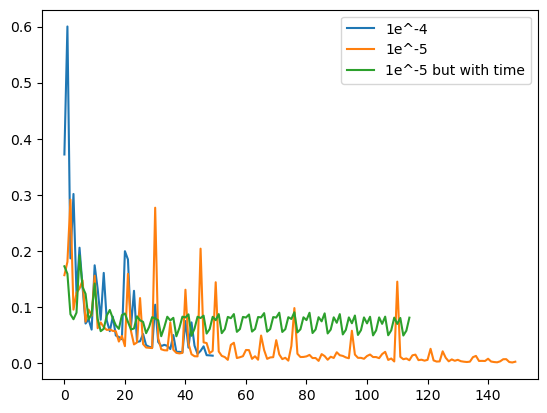

In [36]:
import matplotlib.pyplot as plt

checkpoint = torch.load("saved_model/model_weights.pth")
epoctr = checkpoint['epoch']
lh = checkpoint['loss history']
best_loss = lh[-1]
print("~~MEMORY RESTORED~~")
print(f"LOSS REVERTED ∞ -> {best_loss}")

checkpoint2 = torch.load("saved_model/model_weights2.pth")
epoctr2 = checkpoint2['epoch']
lh2 = checkpoint2['loss history']
best_loss2 = lh2[-1]
print("~~MEMORY RESTORED~~")
print(f"LOSS REVERTED ∞ -> {best_loss2}")

checkpoint = torch.load("saved_model2/model_weights.pth")
epoctr = checkpoint['epoch']
lh3 = checkpoint['loss history']
best_loss = lh3[-1]
print("~~MEMORY RESTORED~~")
print(f"LOSS REVERTED ∞ -> {best_loss}")

cropper = 150
lh2 = lh2[0:cropper]
lh3 = lh3[0:cropper]


plt.plot(lh, label = "1e^-4")
plt.plot(lh2, label = "1e^-5")
plt.plot(lh3, label = "1e^-5 but with time")
# plt.plot(lh3, label = "1e^-4 but long")
plt.legend()


erm time aint looin that good

and a test of the validation

In [33]:
size = len(val_loader.dataset)
num_batches = len(val_loader)

from torch.nn import MSELoss
from snow_model import Net
model = Net().cuda()
loss_fn = MSELoss()



dir_p = "snow_data_processed"
batch_size = 100




val2_x = torch.load(f"{dir_p}\\val_x.pt")
val2_y = torch.load(f"{dir_p}\\val_y.pt")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

val_set2 = TensorDataset(val2_x.float().to(device),val2_y.float().to(device)) 
val_loader = DataLoader(val_set2, batch_size)



checkpoint = torch.load("saved_model/model_weights_around650.pth") # stopped at 65X cuz was taking time
model.load_state_dict(checkpoint)
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        # X,y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
        # print(y)
        # print(pred[:,0])       # has some interesting results showing how argmax
        # print(test_loss)
test_loss /= num_batches
print(f"Val Error for 1e^-4: \nAvg loss: {test_loss:>8f}\n")


checkpoint = torch.load("saved_model/model_weights2.pth")   # ran for 1k and final save was at 723
model.load_state_dict(checkpoint['model'])
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
test_loss /= num_batches
print(f"Val Error for 1e^-5: \nAvg loss: {test_loss:>8f}\n")






val2_x = torch.load(f"{dir_p}\\val_good_x.pt")
val2_y = torch.load(f"{dir_p}\\val_good_y.pt")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

val_set2 = TensorDataset(val2_x.float().to(device),val2_y.float().to(device)) 
val_loader = DataLoader(val_set2, batch_size)



checkpoint = torch.load("saved_model/model_weights_around650.pth") # stopped at 65X cuz was taking time
model.load_state_dict(checkpoint)
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        # X,y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
        # print(y)
        # print(pred[:,0])       # has some interesting results showing how argmax
        # print(test_loss)
test_loss /= num_batches
print(f"Val Error for 1e^-4 with better data: \nAvg loss: {test_loss:>8f}\n")


checkpoint = torch.load("saved_model/model_weights2.pth")   # ran for 1k and final save was at 723
model.load_state_dict(checkpoint['model'])
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
test_loss /= num_batches
print(f"Val Error for 1e^-5 with better data: \nAvg loss: {test_loss:>8f}\n")



Val Error for 1e^-4: 
Avg loss: 0.003593

Val Error for 1e^-5: 
Avg loss: 0.003735

Val Error for 1e^-4 with better data: 
Avg loss: 0.000007

Val Error for 1e^-5 with better data: 
Avg loss: 0.000010



In [34]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from snow_model2 import Net

model = Net().cuda()
loss_fn = MSELoss()

dir_p = "snow_data_processed2"
batch_size = 100


# val2_x = torch.load(f"{dir_p}\\val_good_x.pt")
# val2_y = torch.load(f"{dir_p}\\val_good_y.pt")
val2_x = torch.load(f"{dir_p}\\val_x.pt")
val2_y = torch.load(f"{dir_p}\\val_y.pt")


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


val_set2 = TensorDataset(val2_x.float().to(device),val2_y.float().to(device)) 
val_loader = DataLoader(val_set2, batch_size)



checkpoint = torch.load("saved_model2/model_weights.pth")   # ran for 1k and final save was at 723
model.load_state_dict(checkpoint['model'])
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
test_loss /= num_batches
print(f"Val Error for 1e^-5 with time: \nAvg loss: {test_loss:>8f}\n")




val2_x = torch.load(f"{dir_p}\\val_good_x.pt")
val2_y = torch.load(f"{dir_p}\\val_good_y.pt")
# val2_x = torch.load(f"{dir_p}\\val_x.pt")
# val2_y = torch.load(f"{dir_p}\\val_y.pt")


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


val_set2 = TensorDataset(val2_x.float().to(device),val2_y.float().to(device)) 
val_loader = DataLoader(val_set2, batch_size)



checkpoint = torch.load("saved_model2/model_weights.pth")   # ran for 1k and final save was at 723
model.load_state_dict(checkpoint['model'])
model.eval()
test_loss=0
with torch.no_grad():
    for X,y in val_loader:
        pred = model(X)
        test_loss += loss_fn(pred[:,0],y).item() #item converts tensor to number
test_loss /= num_batches
print(f"Val Error for 1e^-5 with time and better data: \nAvg loss: {test_loss:>8f}\n")

Val Error for 1e^-5 with time: 
Avg loss: 1.593525

Val Error for 1e^-5 with time and better data: 
Avg loss: 1390289648.800000



very close values, though the fac that -5 had a better test error than -4 (not shown since i didnt implement loss graph when running it) may mean that overfitting occured in -5. 

edit: After validating with more accurate mc simulations, the loss decreased by a power of ten for the -4, while the -5 only decreased by a factor of 5. This shows that -5 did in fact overfit. -4 ftw. around 600 epochs, no more no less. 

edit again: loss has fallen after introducing varying start and end dates.
also may have possibly screwed up generation of more pathed data for time inclusive data since idk how avg loss gets fucked up that bad

### Nah, id lose
stuff is still not finished yet :/ 

<img src = pics\galaxy-angel-mint-blancmanche.gif>

on the bright side, that means theres more to come! :)

<img src=pics/reisen-udongein.gif width = 500>

No longer have good computer, cannot fix horrendous loss for time relative version nor can I do much of anything else. Rippers ig. 
A certain disheveled friend would have much to say about this.